In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from statistics import median
import geopandas as gpd
import matplotlib.pyplot as plt
import os

This notebook follows the definition by Lance Freeman to identify gentrified tracts in a given period of time. This concept is applied to Melbourne, Australia in 2 time periods: 2006-2016 and 2011-2016. All three census work with different definition of their geographic units thus making it vital to interpolate 2006 and 2011 geographic divisions to that of 2016. For this we use the notebook included in this same repository called "Areal_Interpolation".

# 1. Central Areas

Tracts need to be located in the central city at the beginning of the intercensal period. Herein, we expand the analysis to all Greater Melbourne.

# 2. Disinvestment Areas

Have a proportion of housing built within the past 20 years lower than the pro- portion found at the median (40th percentile) for the respective metropolitan area. To calculate this we use the number of building permits by Statistical Local Areas and Statistical Area Level 2 provided by ABS within the past 10 years.

In [3]:
def read_table (file_name, sheet=0, header_row=0):
    split_name = file_name.split(".")
    file_type = split_name[len(split_name)-1]
    file =  pd.DataFrame(columns=['colum'])
    if file_type == 'xls' or file_type == 'xlsx' :
        file = pd.read_excel (file_name, sheet_name = sheet, header = header_row)
    elif file_type == 'csv':
        file = pd.read_csv(file_name)
    return file

In [4]:
def load_trim_attr(file_name, columns, filter_path, column_name, sheet=0, header_row=0, code=0):
    #read attribute file
    file = read_table(file_name, sheet, header_row)
    #read filter units file
    filter_units = read_table(filter_path)
    code_header = filter_units.columns[code]
    filter_units[[code_header]]=filter_units[[code_header]].astype(str)
    #Select only code of the geographic units and the number of dwellings as columns
    cols= [list(file.columns)[i] for i in columns]
    file_cols=file[cols]
    #Rename columns
    file_cols.columns = [code_header, cols[1]]
    #Drop NaNs
    file_cols.dropna(inplace =True)
    #Delete blank spaces in the string
    file_cols[code_header] = file_cols[code_header].astype(str)
    file_cols[code_header] = file_cols[code_header].str.replace(' ', '')
    #Get only building permits from Greater Melbourne's geographic units
    result = pd.merge(file_cols, filter_units, how="right", on=code_header)
    #Name number of building permits with the finantial year period
    result.rename(columns={cols[1]: column_name}, inplace=True)
    return result

In [5]:
#Merge all years together
def merge_same_unit_files(same_unit_years, region_code, features):
    i=0
    while i < len(same_unit_years):
        if i == 0:
            data_all_years = pd.merge(same_unit_years[i], same_unit_years[i+1], how="right", on=region_code)
            i = 2
        else:
            data_all_years = pd.merge(data_all_years, same_unit_years[i], how="right", on=region_code)
            i = i+1
    return data_all_years[features + [region_code]]

In [6]:
#Median of the collection of all building permits in Local Statistical Areas
def median_concat_series(all_permits):
    years = all_permits.columns
    numbers = []
    for year in years:
        numbers = numbers + all_permits[year].tolist()
    return numbers

In [7]:
#Load all yearly building permits files
common_path = 'Gentrification_Labels/Disinvestment/Geopandas_Interpolated/'
df_05_06 = read_table(common_path +'2005-2006.csv')
df_06_07 = read_table(common_path +'2006-2007.csv')
df_07_08 = read_table(common_path +'2007-2008.csv')
df_08_09 = read_table(common_path +'2008-2009.csv')
df_09_10 = read_table(common_path +'2009-2010.csv')
df_10_11 = read_table(common_path +'2010-2011.csv')
df_11_12 = read_table(common_path +'2011-2012.csv')
df_12_13 = read_table(common_path +'2012-2013.csv')
df_13_14 = read_table(common_path +'2013-2014.csv')
df_14_15 = read_table(common_path +'2014-2015.csv')
df_15_16 = read_table(common_path +'2015-2016.csv')
SA2_GM_2016 =  read_table('Geographical_Units/Great_Melbourne_Units/SA2_2016_GM.csv')

In [8]:
features = ['2005-2006','2006-2007', '2007-2008','2008-2009', '2009-2010', '2010-2011',
            '2011-2012','2012-2013', '2013-2014','2014-2015', '2015-2016']
SA2_all = merge_same_unit_files([df_05_06, df_06_07, df_07_08, df_08_09, df_09_10, df_10_11, 
                                df_11_12, df_12_13, df_13_14, df_14_15, df_15_16],
                                'SA2_2016_A', features)
median_series_SA2 = median_concat_series(SA2_all[features])
median(median_series_SA2)

233.0000141850712

In [9]:
counter = 0
for col in SA2_all.columns:
    if col in features:
        if counter == 0:
            SA2_all['Average']= pd.to_numeric(SA2_all[col])
        else:
            SA2_all['Average']= SA2_all['Average'] + pd.to_numeric(SA2_all[col])
        counter = counter + 1
SA2_all['Average']= SA2_all['Average']/(counter)

In [10]:
SA2_all['Disinvested'] = np.where(SA2_all['Average']< median(median_series_SA2), True, False)

In [11]:
len(SA2_all[SA2_all['Disinvested']==True])

119

In [12]:
len(SA2_all[SA2_all['Disinvested']== False])

190

In [13]:
def plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col):
    shp = gpd.read_file(shp_path).to_crs(crs)
    #unify pivot columns' name
    shp.rename(columns={shp_pivot_col: attr_pivot_col}, inplace=True)
    #Cast codes to string
    shp[[attr_pivot_col]] = shp[[attr_pivot_col]].astype(str)
    attr_table[[attr_pivot_col]] = attr_table[[attr_pivot_col]].astype(str)
    #join
    shp_attr = shp.merge(attr_table, on=attr_pivot_col, how="right")
    shp_attr.plot(column=attribute,legend=True, figsize=(20,10))

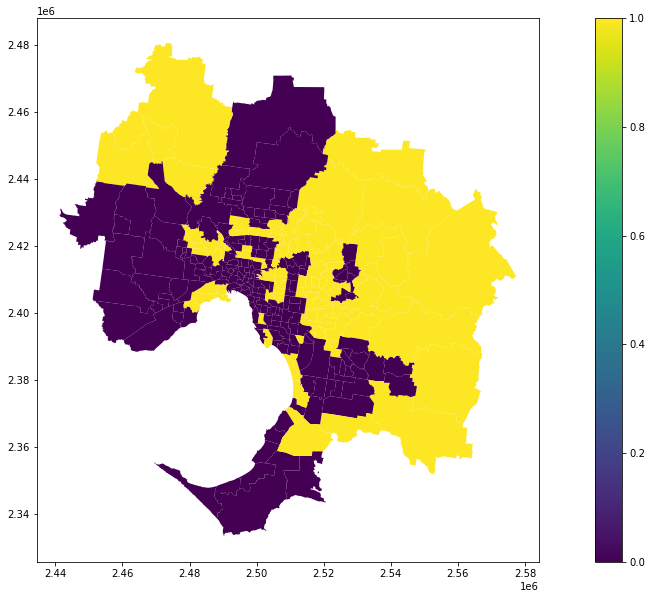

In [14]:
shp_path = 'Shapefiles/Great_Melbourne/SA2_2016_GM/SA2_GreaterMelbourne.shp'
crs = 7899
attribute = 'Disinvested'
attr_table = SA2_all
attr_pivot_col = 'SA2_2016_A'
shp_pivot_col = 'SA2_2016_A'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

In [ ]:
SA2_all.to_csv('Gentrification_Labels/Disinvestment/SA2_2016_disinv_outcome.csv',index=False)

# 3. Educational Atainment as Proxy of Class

Freeman implements the following rule: a neighborhood must have an increase in educational attainment, measured as the percentage of those 25 years and older with at least four years of college (an undergraduate degree in the US), greater than or equal to the average increase in educational attainment in the neighborhood’s respective metropolitan area. We refer to the Australian censuses of 2006, 2011 and 2016 disregarding the age requirement as it is not included in the datapacks of the last 2 censuses.

Data:
- Non_school_qualifications_Bachelor_Degree_Level_Persons (2011, 2016)
- University or other Tertiary Institutions: Full-time student: Aged 25 years and over,Persons (2006)
- University or other Tertiary Institutions: Part-time student: Aged 25 years and over,Persons (2006)
- University or other Tertiary Institutions: Full/Part-time student status not stated,Persons (2006)


In [15]:
def mean_threshold_classify (start_attr_file_path, end_attr_file_path, filter_units_path, attr_name,
                             caclulated_name, start_columns, end_columns, code):
    #Calculate mean of the end date
    attr_end = load_trim_attr(end_attr_file_path, end_columns, filter_units_path, attr_name, code=code)
    end_mean = attr_end[attr_name].mean()
    #Calculate mean of the start date
    attr_start = load_trim_attr(start_attr_file_path, start_columns, filter_units_path, attr_name, code=code)
    start_mean = attr_start[attr_name].mean()
    #Calculate change of between dates
    threshold = (end_mean-start_mean)/end_mean
    #Allocate labels for attribute regarding threshold
    outcome = attr_start[[attr_start.columns[0]]]
    outcome['attr_start'] = attr_start[attr_name]
    outcome['attr_end'] = attr_end[attr_name]
    outcome['change'] = (outcome['attr_end']-outcome['attr_start'])/outcome['attr_start']
    outcome['change'] = outcome['change'].replace({np.inf: 0})
    outcome[caclulated_name] = np.where(outcome['change']> threshold, True, False)
    #Print results
    print('tracts with '+ caclulated_name + ' ' + str(len(outcome[outcome[caclulated_name] == True])))
    print('tracts without '+ caclulated_name + ' '  + str(len(outcome[outcome[caclulated_name] == False])))
    return outcome

## 2011-2016

In [16]:
filter_units_path = 'Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv'
end_attr_file_path = 'Gentrification_Labels/Educational_Attainment/2016Census_G40_VIC_SA1.csv'
start_attr_file_path = 'Gentrification_Labels/Educational_Attainment/Geopandas_Interpolated/' +\
                       'Educational_Atainment_2011.csv'
attr_name = 'Educational_Atainment'
caclulated_name = 'Influx_affluent'
start_columns = [0,2]
end_columns = [0,39]

In [19]:
influx_affluent_11_16 = mean_threshold_classify(start_attr_file_path, end_attr_file_path, filter_units_path, 
                                                  attr_name,caclulated_name,start_columns,end_columns,
                                                  code=1)

tracts with Influx_affluent 7557
tracts without Influx_affluent 2732


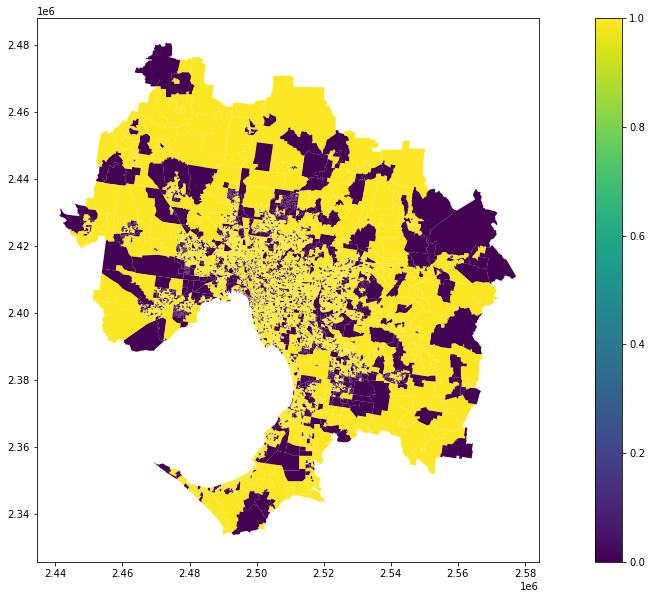

In [20]:
shp_path = 'Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = caclulated_name
attr_table = influx_affluent_11_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

In [ ]:
influx_affluent_11_16.to_csv('Gentrification_Labels/Educational_Attainment/EA_11_16_SA1_outcome.csv',index=False)

## 2006-2016

In [21]:
filter_units_path = 'Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv'
end_attr_file_path = 'Gentrification_Labels/Educational_Attainment/2016Census_G40_VIC_SA1.csv'
start_attr_file_path = 'Gentrification_Labels/Educational_Attainment/Geopandas_Interpolated/' +\
                       'Educational_Atainment_2006.csv'
attr_name = 'Educational_Atainment'
caclulated_name = 'Influx_affluent'
start_columns = [1,2]
end_columns = [0,39]

In [22]:
influx_affluent_06_16 = mean_threshold_classify(start_attr_file_path, end_attr_file_path, filter_units_path, 
                                                  attr_name,caclulated_name,start_columns,end_columns,code=1)

tracts with Influx_affluent 9587
tracts without Influx_affluent 702


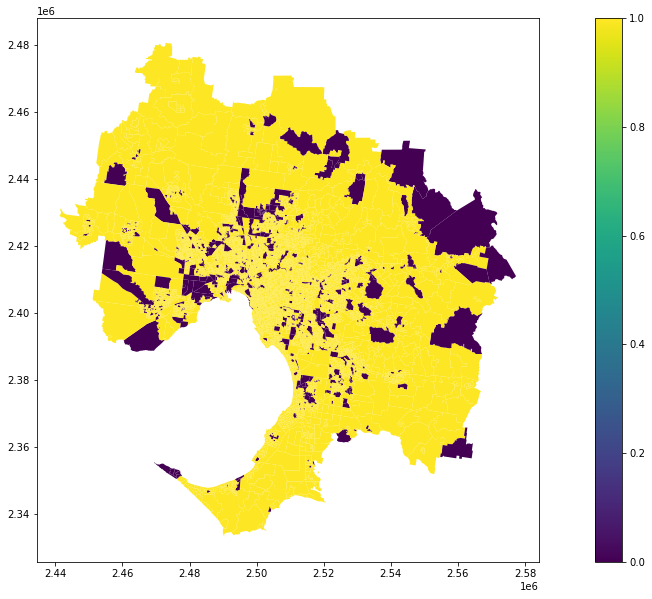

In [23]:
shp_path = 'Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = caclulated_name
attr_table = influx_affluent_06_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

In [ ]:
influx_affluent_06_16.to_csv('Gentrification_Labels/Educational_Attainment/EA_06_16_SA1_outcome.csv',index=False)

# 4. Low-Income Households

Have a median income less than the median (40th percentile) for that metropolitan area at the beginning of the intercensal period.
Data: 
- Median_total_household_income_weekly (2006)
- Median household income ($/week) (2011)


In [24]:
filter_units_path = 'Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv'
attr_file_path = 'Gentrification_Labels/Income/Geopandas_Interpolated/Income_2011.csv'
attr_name = 'Income'
calculated_attr = 'low_income'
columns = [1,2]
code = 1
quantile = 0.4

In [32]:
def quantile_threshold_classify(attr_file_path, columns, filter_units_path, attr_name, quantile, 
                                calculated_attr, code=0):
    trimmed_attr = load_trim_attr(attr_file_path, columns, filter_units_path, attr_name, code=code)
    trim_attr_quantile = trimmed_attr[attr_name].quantile(quantile)
    trimmed_attr[calculated_attr] = np.where(trimmed_attr[attr_name]< trim_attr_quantile, True, False)
    #Print results
    print('tracts with '+ caclulated_name + ' ' + \
          str(len(trimmed_attr[trimmed_attr[calculated_attr] == True])))
    print('tracts without '+ caclulated_name + ' '  + \
          str(len(trimmed_attr[trimmed_attr[calculated_attr] == False])))
    return trimmed_attr

In [33]:
income_11_16 = quantile_threshold_classify (attr_file_path, columns, filter_units_path, 
                                            attr_name, quantile, calculated_attr, code= code)

tracts with Influx_affluent 4116
tracts without Influx_affluent 6173


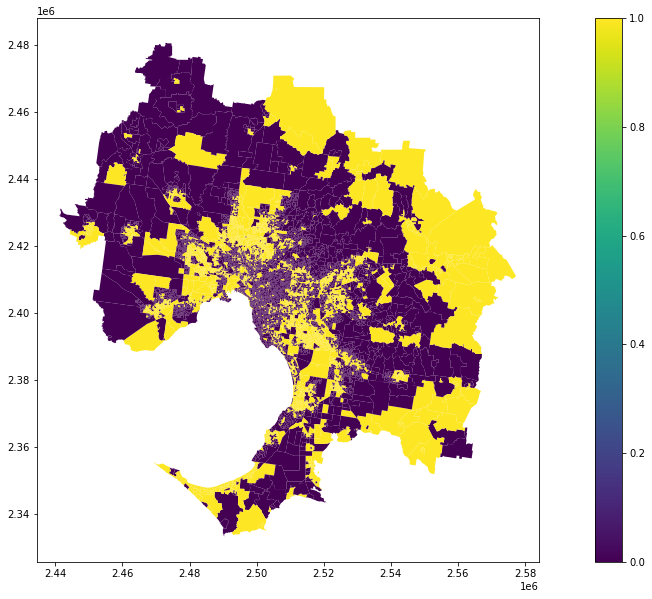

In [34]:
shp_path = 'Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = calculated_attr
attr_table = income_11_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

In [35]:
filter_units_path = 'Geographical_Units/Great_Melbourne_Units/SA1_2016_GM.csv'
attr_file_path = 'Gentrification_Labels/Income/Geopandas_Interpolated/Income_2006.csv'
attr_name = 'Income'
calculated_attr = 'low_income'
columns = [1,2]
code = 1
quantile = 0.4

In [209]:
income_06_16 = quantile_threshold_classify (attr_file_path, columns, filter_units_path, 
                                            attr_name, quantile, calculated_attr, code= code)

tracts with Influx_affluent 4116
tracts without Influx_affluent 6173


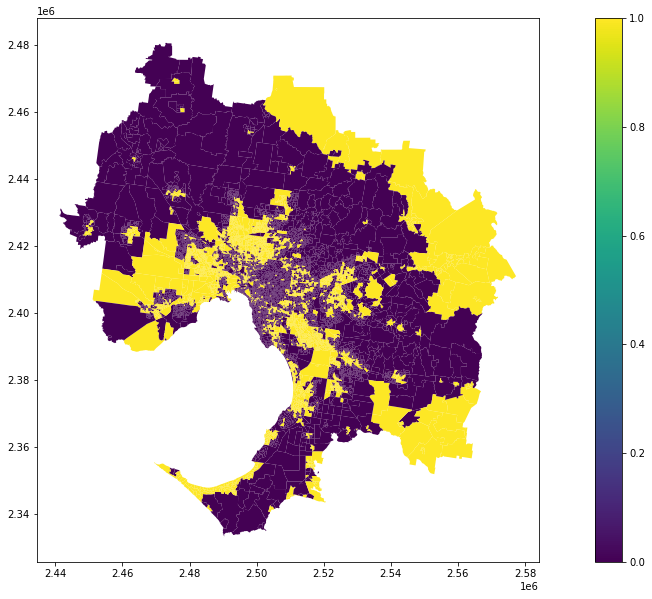

In [37]:
shp_path = 'Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = calculated_attr
attr_table = income_06_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

# 5. Reinvestment

Any increae in house prices is considered a proxy of investment.

In [174]:
def load_csv_in_carpet(rootdir, mask_path, year):
    counter =  1
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            filepath = subdir + os.sep + file
            if filepath.endswith(".csv"):
                attr_name = year+'_'+str(counter)
                if counter ==1:
                    merging_table = load_trim_attr(filepath, [0,1], mask_path, attr_name, code=0)
                else:
                    new_df = load_trim_attr(filepath, [0,1], mask_path, attr_name, code=0)
                    merging_table[attr_name] = pd.to_numeric(new_df[attr_name])
                counter = counter + 1
                merging_table = merging_table[merging_table.columns[0:counter]]

    attrs_fillna=merging_table[merging_table.columns[1:counter]].apply(lambda row: row.fillna(row.mean()), axis=1)
    result = pd.concat([merging_table[merging_table.columns[0]], attrs_fillna], axis=1, join="inner") 
    result['mean_'+year] = result.iloc[:, 1:counter].mean(axis=1)
    result.fillna(result.mean(), inplace =True)
    return result

In [176]:
rootdir = 'Gentrification_Labels/House_Prices/2016'
mask_path = 'Geographical_Units/Great_Melbourne_Units/SA2_2011_GM.csv'
year ='2016'

house_median_2016 = load_csv_in_carpet(rootdir, mask_path, year)
house_median_2016.to_csv('Gentrification_Labels/House_Prices/mean_median_SA2_2011/house_prices_2016.csv',
                         index=False)

In [177]:
rootdir = 'Gentrification_Labels/House_Prices/2011'
mask_path = 'Geographical_Units/Great_Melbourne_Units/SA2_2011_GM.csv'
year ='2011'

house_median_2011 = load_csv_in_carpet(rootdir, mask_path, year)
house_median_2011.to_csv('Gentrification_Labels/House_Prices/mean_median_SA2_2011/house_prices_2011.csv',
                         index=False)

In [178]:
rootdir = 'Gentrification_Labels/House_Prices/2006'
mask_path = 'Geographical_Units/Great_Melbourne_Units/SA2_2011_GM.csv'
year ='2006'

house_median_2006 = load_csv_in_carpet(rootdir, mask_path, year)
house_median_2006.to_csv('Gentrification_Labels/House_Prices/mean_median_SA2_2011/house_prices_2006.csv',
                         index=False)

Interpolation of those values from SA2_2011 to SA2_2016 is required. It is performed with the notebook: "Areal_Interpolation"

In [233]:
df_mean_2006 = read_table('Gentrification_Labels/House_Prices/Geopandas_Interpolated/House_Price_2006.csv')
df_mean_2011 = read_table('Gentrification_Labels/House_Prices/Geopandas_Interpolated/House_Price_2011.csv')
df_mean_2016 = read_table('Gentrification_Labels/House_Prices/Geopandas_Interpolated/House_Price_2016.csv')

HV_all_years = pd.concat([df_mean_2006[['SA1_MAINCO','SA1_7DIG16','House_Price_2006']],
                                   df_mean_2011[['House_Price_2011']],
                                   df_mean_2016[['House_Price_2016']]],
                                   axis=1, join="inner") 

HV_all_years.fillna(0, inplace=True)

In [227]:
def house_value_increase(df, start_column, end_column, calculated_attr):
    df[calculated_attr] = np.where(df[end_column]>= df[start_column], True, False)
    print('tracts with increased house prices ' + str(len(df[df[calculated_attr] == True])))
    print('tracts without increased house prices '  + str(len(df[df[calculated_attr] == False])))
    return df

### 2011-2016

In [235]:
reinvestment_11_16 = house_value_increase(HV_all_years, 'House_Price_2011', 'House_Price_2016', 
                                          'increased_11_16')

tracts with increased house prices 9984
tracts without increased house prices 305


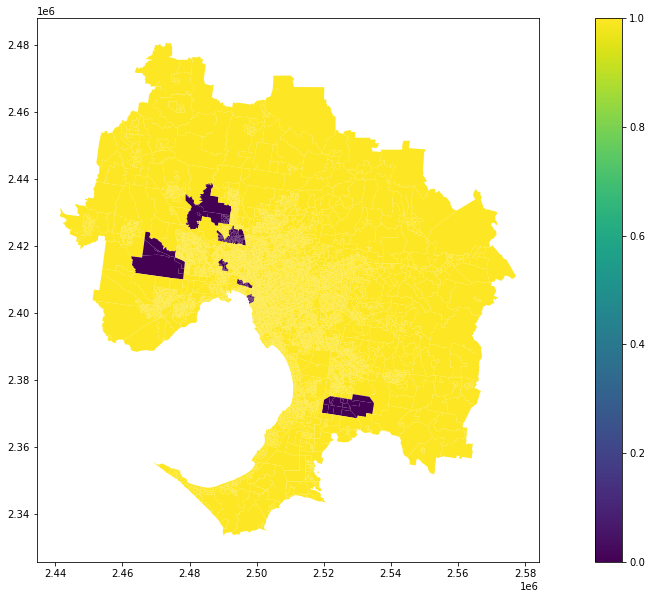

In [194]:
shp_path = 'Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = 'increased_11_16'
attr_table = reinvestment_11_16
attr_pivot_col = 'SA1_7DIG16'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

### 2006-2016

In [229]:
reinvestment_06_16 = house_value_increase(HV_all_years, 'House_Price_2006', 'House_Price_2016', 
                                          'increased_06_16')

tracts with increased house prices 10260
tracts without increased house prices 29


tracts with increased house prices 10260
tracts without increased house prices 29


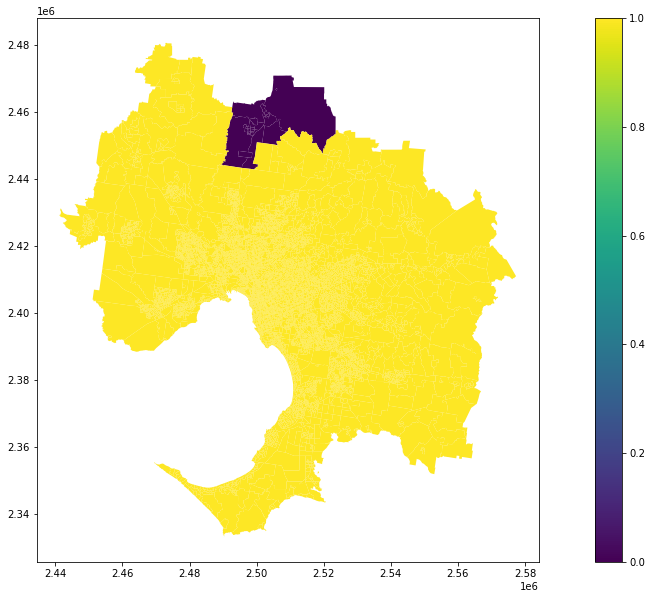

In [223]:
shp_path = 'Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = 'increased_06_16'
attr_table = reinvestment_06_16
attr_pivot_col = 'SA1_7DIG16'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

# 6. Gentrification Classification

In [210]:
def merge_str(left_df, right_df, left_col, right_col, how):
    right_df.rename(columns={right_col: left_col}, inplace=True)
    right_df[left_col] = right_df[left_col].astype(str)
    left_df[left_col] = left_df[left_col].astype(str)
    left_df = pd.merge(left_df, right_df, how=how, on=left_col)
    return left_df

## 2006-2016

In [269]:
final_label_06_16 = SA2_all[['SA2_2016_A','Disinvested']]
final_label_06_16 = merge_str(final_label_06_16, income_06_16[['SA1_7DIGITCODE_2016','SA2_MAINCODE_2016','low_income']],
                       'SA2_2016_A', 'SA2_MAINCODE_2016', 'right')
final_label_06_16 = merge_str(final_label_06_16, influx_affluent_06_16[['SA1_7DIGITCODE_2016', 'Influx_affluent']],
                       'SA1_7DIGITCODE_2016','SA1_7DIGITCODE_2016', 'left')
final_label_06_16 = merge_str(final_label_06_16, reinvestment_06_16[['SA1_7DIG16', 'increased_06_16']],
                       'SA1_7DIGITCODE_2016','SA1_7DIG16', 'left')
final_label_06_16['Gentrified_06_16'] = final_label_06_16['Disinvested'] & final_label_06_16['low_income'] & \
                            final_label_06_16['Influx_affluent'] & final_label_06_16['increased_06_16']

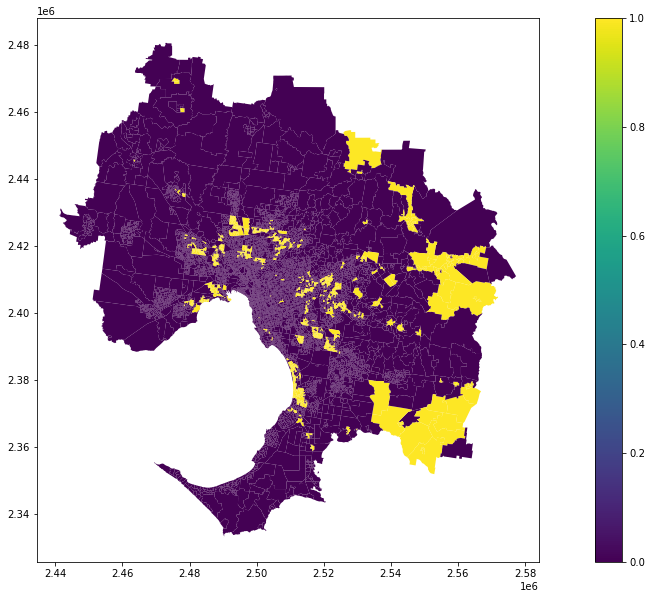

In [271]:
shp_path = 'Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = 'Gentrified_06_16'
attr_table = final_label_06_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)

## 2011-2016

In [267]:
final_label_11_16 = SA2_all[['SA2_2016_A','Disinvested']]
final_label_11_16 = merge_str(final_label_11_16, income_11_16[['SA1_7DIGITCODE_2016','SA2_MAINCODE_2016',
                                                               'low_income']],
                       'SA2_2016_A', 'SA2_MAINCODE_2016', 'right')
final_label_11_16 = merge_str(final_label_11_16, influx_affluent_11_16[['SA1_7DIGITCODE_2016', 'Influx_affluent']],
                       'SA1_7DIGITCODE_2016','SA1_7DIGITCODE_2016', 'left')
final_label_11_16 = merge_str(final_label_11_16, reinvestment_11_16[['SA1_7DIG16', 'increased_11_16']],
                       'SA1_7DIGITCODE_2016','SA1_7DIG16', 'left')
final_label_11_16['Gentrified_11_16'] = final_label_11_16['Disinvested'] & final_label_11_16['low_income'] & \
                            final_label_11_16['Influx_affluent'] & final_label_11_16['increased_11_16']

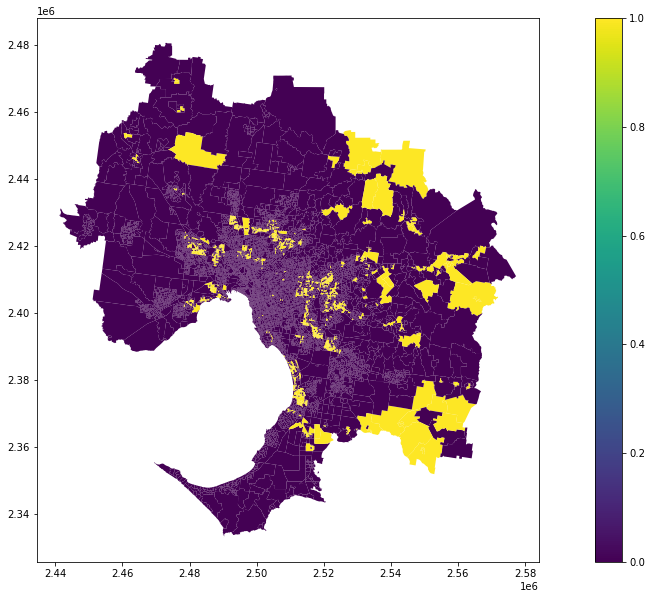

In [268]:
shp_path = 'Shapefiles/un-trimmed/SA1_2016_Australia/SA1_2016_AUST.shp'
crs = 7899
attribute = 'Gentrified_11_16'
attr_table = final_label_11_16
attr_pivot_col = 'SA1_7DIGITCODE_2016'
shp_pivot_col = 'SA1_7DIG16'
plot_categorical_attr(shp_path, crs, attribute, attr_table, attr_pivot_col, shp_pivot_col)